<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
rasterio==1.2.0
numpy==1.21.6
radiant_mlhub==0.4.1
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
pillow==7.1.2
monai==0.9.1
tensorboard==2.8.0

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

In [75]:
import os
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
import pylab as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss, MaskedDiceLoss
from monai.metrics import DiceMetric
# from torch.utils.tensorboard import SummaryWriter

## Specify global parameters

In [4]:
data_dir = 'data'
random_seed = 42

train_df_path = 'train_data.csv'

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

In [5]:
np.random.seed(random_seed)

## Download data from MLHUB


In [6]:
collection_name = 'ref_agrifieldnet_competition_v1'

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [7]:
if not os.path.exists(data_dir):
  os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

  dataset = Dataset.fetch(collection_name)
  dataset.download(output_dir=data_dir)
  for fn in os.listdir(data_dir):
    with tarfile.open(os.path.join(data_dir, fn)) as f:
      f.extractall(data_dir + '/') 
    os.remove(os.path.join(data_dir, fn))
else:
  print("Dataset already exists")

Dataset already exists


## Prepare Training data


### Create training dataframe

In [8]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths if 'labels_train' in fn]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [9]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

,folder_id,field_path,label_path,source_path
0,485ab,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
1,47271,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
2,1c08c,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
3,5c4fa,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
4,200d3,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...


## Extract field-crop data

In [70]:
field_ids = []
crop_type = []
field_area = []
field_max_dim = []
field_center_x = []
field_center_y = []

for i in tqdm(range(len(train_data))):
    with rasterio.open(train_data['field_path'].iloc[i]) as src:
        field_data = src.read()[0]
    with rasterio.open(train_data['label_path'].iloc[i]) as src:
        crop_data = src.read()[0]

    for field_id in np.unique(field_data)[1:]:
        ind = np.where(field_data == field_id)
        field_ids.append(field_id)
        crop_type.append(np.unique(crop_data[ind])[-1])
        field_area.append(len(ind[0]))
        field_max_dim.append(np.max(np.array(ind).max(1) - np.array(ind).min(1) + 1))
        field_center_y.append(np.mean(ind[0]))
        field_center_x.append(np.mean(ind[1]))

100%|██████████████████████████████████████████████████| 1165/1165 [00:07<00:00, 152.83it/s]


In [71]:
df = pd.DataFrame(np.array([field_ids, crop_type, field_area, 
                            field_max_dim, field_center_x, field_center_y]).transpose(),
                  columns=['field_id', 'crop_type', 'field_area', 
                           'field_max_dim', 'center_x', 'center_y'])

In [72]:
df = df.sort_values(['crop_type', 'field_id']).reset_index(drop=True)
df['count'] = 1

In [73]:
df.groupby('crop_type').sum()

,field_id,field_area,field_max_dim,center_x,center_y,count
crop_type,,,,,,
1.0,6241369.0,75118.0,17357.0,268141.027810,272345.129440,2148
2.0,3951325.0,46818.0,9542.0,134534.280499,135859.037956,1041
3.0,197850.0,2883.0,786.0,14378.647796,13225.595171,105
4.0,6633376.0,36397.0,10366.0,214265.322749,221002.721353,1707
5.0,53102.0,531.0,177.0,3473.416281,3866.649834,25
6.0,279015.0,5820.0,1451.0,22128.328845,21726.170139,173
8.0,255632.0,3150.0,526.0,5984.146869,6461.463742,49
9.0,2000157.0,8773.0,2275.0,37997.718876,38870.447163,304
13.0,360261.0,3503.0,647.0,6351.534183,7946.557215,64


### Split the data into train and validation

In [76]:
val_fraction = 0.2

In [88]:
df_train = []
df_val = []
for crop in df['crop_type'].unique():
    cur_df = df[df['crop_type'] == crop].reset_index(drop=True)
    unique_field_ids = cur_df['field_id'].unique()
    ind = np.arange(len(unique_field_ids))
    np.random.shuffle(ind)
    n_val = int(round(val_fraction * len(ind)))
    df_val.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[:n_val]])])
    df_train.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[n_val:]])])
df_train = pd.concat(df_train, ignore_index=True)
df_val = pd.concat(df_val, ignore_index=True)

In [104]:
n_fields = np.array(df_train.groupby('crop_type').sum()['count'])
weights = np.max(n_fields) / n_fields
crop_labels = np.unique(df_train['crop_type'])

In [105]:
crop_labels, weights

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 13., 14., 15., 16., 36.]),
 array([  1.        ,   2.07220217,  20.74698795,   1.26431718,
         90.63157895,  12.66176471,  44.15384615,   7.02857143,
         33.11538462, 156.54545455,  49.2       , 132.46153846,
         16.55769231]))

## Extract labels

In [14]:
with open(f'{data_dir}/{train_label_collection}/{train_label_collection}'
          f'_{train_data.iloc[0]["folder_id"]}/stac.json') as ll:
    label_json = json.load(ll)

In [106]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

## Specify Data Loading pipeline

### Specify parameters

In [16]:
batch_size = 16

### Specify the Dataset

In [17]:
class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df, phase='train', transforms=None, 
               band_names=BAND_NAMES):
    assert phase in ['train', 'validation']
    self.df = df[df['split'] == phase]
    self.transforms = transforms
    self.band_names = band_names

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64)/255.)
    with rasterio.open(self.df.iloc[index]['label_path']) as src:
      labels = src.read()[0].astype(np.int64)

    labels = torch.tensor(labels).unsqueeze(0)
    imgs = torch.tensor(np.array(imgs))
      
    if self.transforms:
      seed = np.random.randint(np.iinfo('int32').max)
      torch.manual_seed(seed)
      labels = self.transforms(labels)
      torch.manual_seed(seed)
      imgs = self.transforms(imgs)


      # new_imgs = []
      # for img in imgs:
      #   torch.manual_seed(seed)
      #   new_imgs.append(self.transforms(img.unsqueeze(0)))
      # imgs = torch.stack(new_imgs).squeeze(1)

    return imgs.float(), labels
    

  def __len__(self):
    return len(self.df)

### Specify transforms

In [18]:
train_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
        torch_transforms.RandomRotation(degrees=30),
    ])

validation_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
    ])

### Test the loaders

In [19]:
np.random.seed(random_seed)
dl_train0 = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='train', 
                # transforms=train_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_train = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='train', 
                transforms=train_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='validation', 
                transforms=validation_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [20]:
imgs, labels = next(iter(dl_train))
imgs0, labels0 = next(iter(dl_train0))

In [21]:
imgs.shape, labels.shape

(torch.Size([16, 12, 256, 256]), torch.Size([16, 1, 256, 256]))

In [55]:
ind = 1
s = 3

/home/anna/anaconda3/envs/agri/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


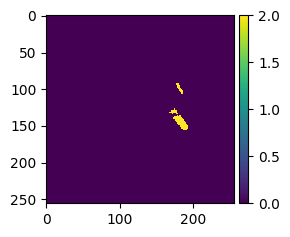

In [56]:
plt.figure(figsize=(s,s))
io.imshow(labels[ind][0].numpy())

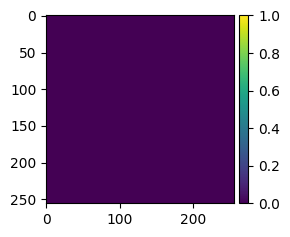

In [33]:
plt.figure(figsize=(s,s))
io.imshow(labels0[ind][0].numpy())

In [25]:
sl0 = tuple([slice(70, 100), slice(20, 50)])
sl = tuple([slice(190, 220), slice(40, 70)])

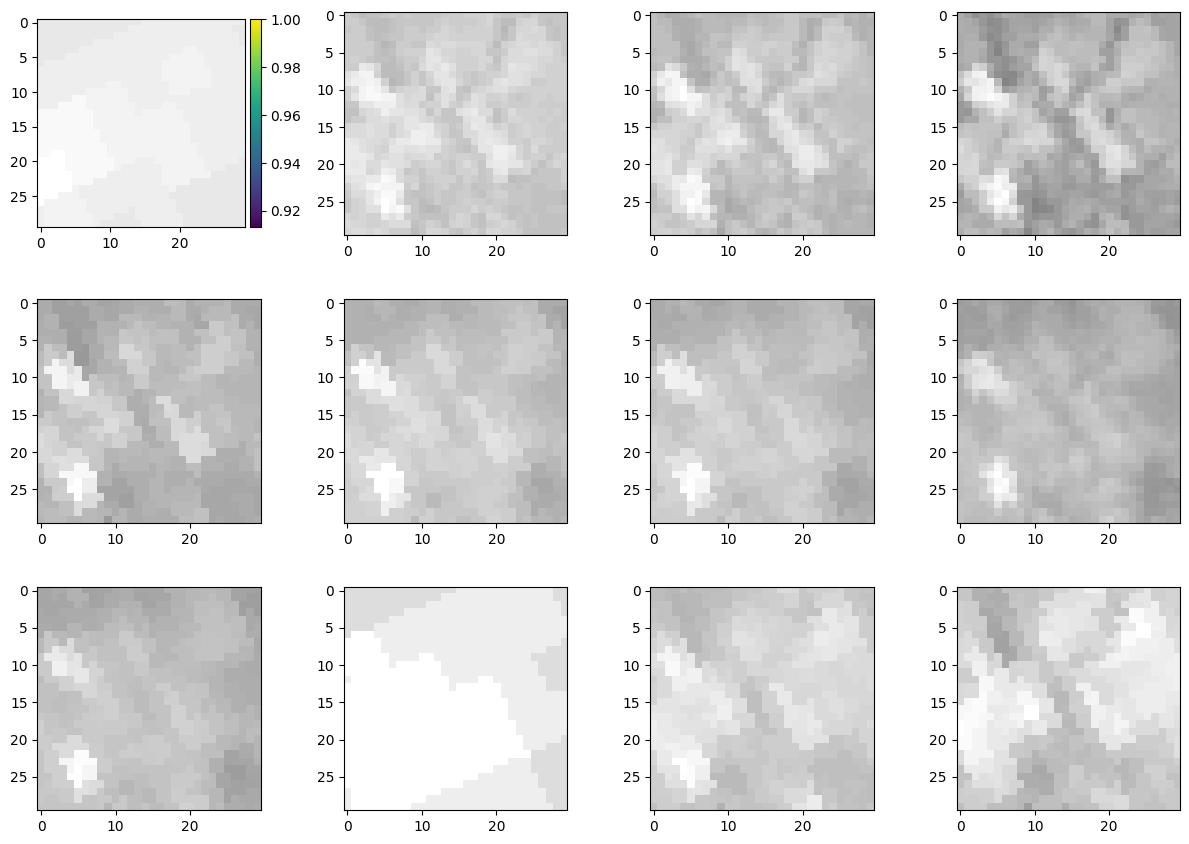

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(s*4, s*3))
for ax, img in zip(axes.ravel(), imgs[ind]):
  plt.sca(ax)
  im = img[sl].numpy()
  im = im / np.max(im)
  io.imshow(mark_boundaries(im, labels[ind][0][sl].numpy(), 
                            mode='outer'))

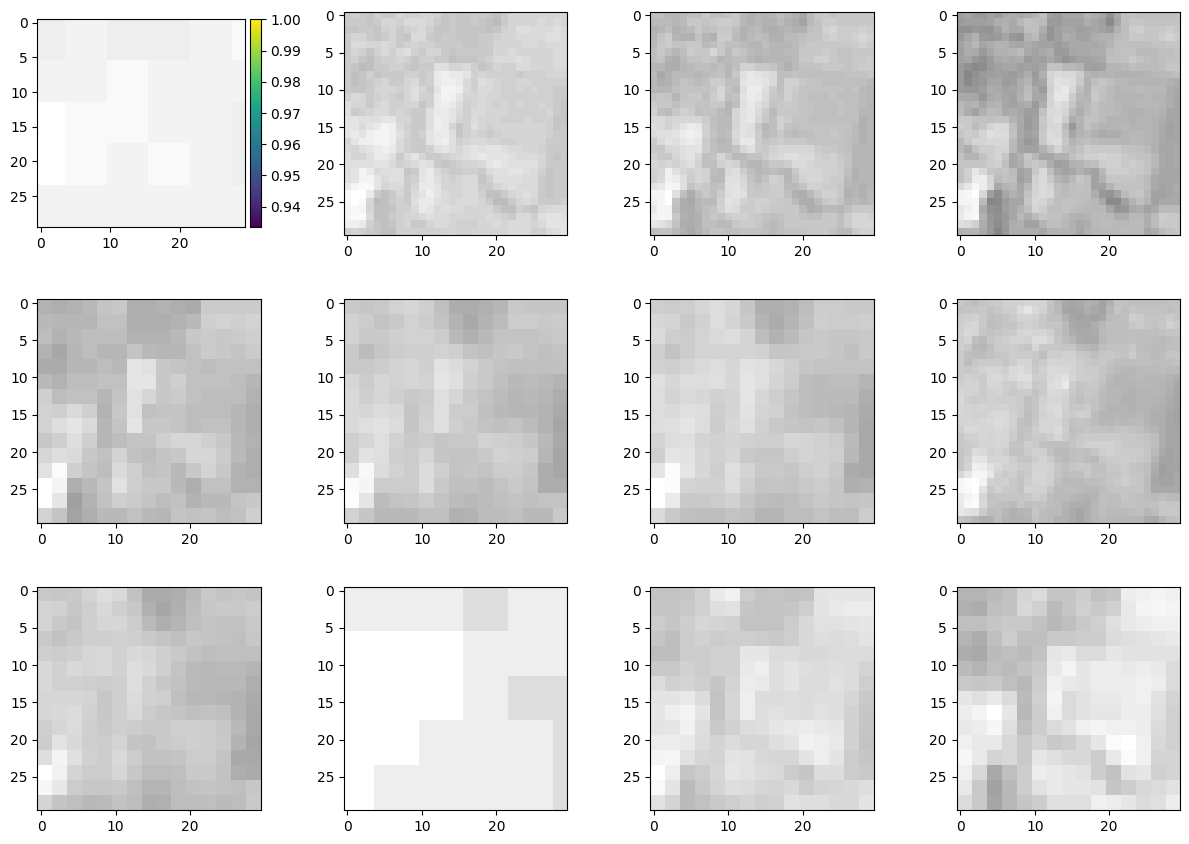

In [27]:
fig, axes = plt.subplots(3, 4, figsize=(s*4, s*3))
for ax, img in zip(axes.ravel(), imgs0[ind]):
  plt.sca(ax)
  im = img[sl0].numpy()
  im = im / np.max(im)
  io.imshow(mark_boundaries(im, labels0[ind][0][sl0].numpy(), 
                            mode='outer'))

### Specify the loaders

In [28]:
np.random.seed(random_seed)

dl_train = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='train', 
                transforms=train_transforms
                ), 
    shuffle=True, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='validation', 
                transforms=validation_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

## Specify the training pipeline

### Parameters

In [29]:
out_channels = np.max(crop_labels) + 1
n_channels = (32, 64, 128, 256, 512)
lr = 0.0001
weight_decay = 0.0005
factor = 0.1
patience = 20
epochs = 100

### Model and loss

In [30]:
net = UNet(
    spatial_dims=2,
    in_channels=len(BAND_NAMES),
    out_channels=out_channels,
    channels=n_channels,
    strides=(2,) * (len(n_channels) - 1),
    num_res_units=2,
    norm=Norm.BATCH,
).cuda()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
class MaskedDiceCELoss(nn.Module):

  def __init__(self, include_background=False, to_onehot_y=True, softmax=True,
               dice_ce_weight=1, dice_mask_weight=1):
    
    super().__init__()
    self.diceCELoss = DiceCELoss(include_background=include_background, 
                                 to_onehot_y=to_onehot_y, 
                                 softmax=softmax)
    self.diceMasked = MaskedDiceLoss(include_background=include_background, 
                                       to_onehot_y=to_onehot_y, 
                                       softmax=softmax)
    self.dice_ce_weight = dice_ce_weight
    self.dice_mask_weight = dice_mask_weight

  def forward(self, input, target, mask):
    loss1 = self.diceCELoss(input, target)*self.dice_ce_weight 
    loss2 = self.diceMasked(input, target, mask)*self.dice_mask_weight
    return loss1 + loss2

In [ ]:
loss_fn = MaskedDiceCELoss(include_background=False, 
                           to_onehot_y=True, softmax=True).cuda()
metric = DiceMetric(include_background=False, reduction="mean")

### Optimizer and scheduler

In [ ]:
optimizer = torch.optim.AdamW(
    params=[{"params": [p for p in net.parameters() if p.requires_grad]}],
            lr=lr, weight_decay=weight_decay
            )

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=factor, patience=patience
    )

### Training step

In [ ]:
def train_epoch(net, loss_fn, dl_train, optimizer):
  net.train()
  loss_fn.train()
  epoch_loss = 0
  step = 0
  for imgs, targets in tqdm(dl_train):
    step += 1
    optimizer.zero_grad()
    outputs = net(imgs.cuda())
    losses = loss_fn(outputs, targets.cuda(), targets.cuda() > 0)
    losses.backward()
    optimizer.step()
    epoch_loss += losses.item()
  epoch_loss /= step
  return epoch_loss

### Validation step

In [ ]:
def validate_epoch(net, loss_fn, dl_val, metric):
  net.eval()
  loss_fn.eval()
  epoch_loss = 0
  step = 0

  with torch.no_grad():
    for imgs, targets in tqdm(dl_val):
      step += 1
      outputs = net(imgs.cuda())
      losses = loss_fn(outputs, targets.cuda(), targets.cuda() > 0)
      epoch_loss += losses.item()
      metric(outputs.argmax(1).unsqueeze(1), targets.cuda())
  epoch_loss /= step
  return epoch_loss, metric

## Train the model

In [ ]:
%%time
train_losses = []
val_losses = []
val_metrics = []
for epoch in range(epochs):
    # training pass
    train_loss = train_epoch(net, loss_fn, dl_train, optimizer)

    # validation pass
    val_loss, metric = validate_epoch(net, loss_fn, dl_val, metric)
    val_metric = metric.aggregate().item()
    metric.reset()

    # update learning rate
    lr_scheduler.step(val_loss)

    # output
    print(f"epoch {epoch + 1} training loss: {train_loss:.4f}; "
          f"validation loss: {val_loss:.4f}; Dice metric: {val_metric:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'r')
plt.plot(val_losses, 'b')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(val_metrics,'r')

In [ ]:
torch.save(net.state_dict(), 'model.pth')

In [ ]:
from google.colab import files
files.download('model.pth')

## Set up the loaders and model for evaluation

In [ ]:
class AgriDatasetTest(torch.utils.data.Dataset):

  def __init__(self, df, band_names=BAND_NAMES):
    self.band_names = band_names
    self.df = df

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64)/255.)
    
    with rasterio.open(self.df.iloc[index]['field_path']) as src:
      labels = src.read()[0].astype(np.int64)

    if os.path.exists(self.df.iloc[index]['label_path']):
      with rasterio.open(self.df.iloc[index]['label_path']) as src:
        gt = src.read()[0].astype(np.int64)
        gt = torch.tensor(gt)
    else:
      gt = labels

    labels = torch.tensor(labels)
    imgs = torch.tensor(np.array(imgs))

    return imgs.float(), labels, gt

  def __len__(self):
    return len(self.df)

In [ ]:
dl_test = torch.utils.data.DataLoader(
    AgriDatasetTest(train_data[train_data['split'] == 'validation']),
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [ ]:
net.load_state_dict(torch.load('model.pth'))
net.eval();

## Evaluate the model on the validation set

In [ ]:
def evaluate(dl_test, net):
  field_data = dict()
  gt_labels = dict()
  with torch.no_grad():
    for imgs, labels, gt in tqdm(dl_test):
      output = net(imgs.cuda()).cpu()
      output = output.numpy()
      labels = labels.numpy()
      output = np.moveaxis(output, 1, -1)

      llist = np.unique(labels)[1:]
      for lb in llist:
        ind = np.where(labels == lb)
        data = output[ind]
        if lb in field_data.keys():
          field_data[lb] = np.concatenate([field_data[lb], data], axis=0)
        else:
          field_data[lb] = data

        data = gt[ind]
        if lb in gt_labels.keys():
          gt_labels[lb] = np.concatenate([gt_labels[lb], data], axis=0)
        else:
          gt_labels[lb] = data
        
  field_ids = []
  probs = []
  gt = []
  for key in field_data.keys():
    field_ids.append(key)
    prob = field_data[key].mean(0)[crop_labels]
    prob = prob - np.min(prob)
    prob = prob / np.sum(prob)
    probs.append(prob)
    gt.append(gt_labels[key][0].item())
  probs = np.array(probs)
  return probs, field_ids, gt

In [ ]:
probs, field_ids, gt = evaluate(dl_test, net)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(gt, np.array(crop_labels)[np.argmax(probs, axis=1)]))

In [ ]:
def to_one_hot(x):
    y = np.zeros((x.size, x.max() + 1))
    y[np.arange(x.size), x] = 1
    return y

def cross_entropy(predictions, targets):
    return -np.sum(np.sum(np.log(predictions + 10**(-10)) * targets, axis=1))/len(targets)


In [ ]:
targets = to_one_hot(np.array(gt))
targets = targets[:, np.where(targets.sum(axis=0) > 0)[0]]

In [ ]:
cross_entropy(probs, targets)

## Prepare the test dataset

In [ ]:
test_paths = os.listdir(os.path.join(data_dir, test_label_collection))
test_ids = [fn.split('_')[-1] for fn in test_paths if 'labels_test' in fn]

field_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/field_ids.tif' 
               for i in test_ids]
label_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/raster_labels.tif' 
               for i in test_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in test_ids]

In [ ]:
test_data = pd.DataFrame(np.array([test_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
test_data.head()

## Evaluate the model on the test set

In [ ]:
dl_test = torch.utils.data.DataLoader(
    AgriDatasetTest(test_data), shuffle=False, batch_size=batch_size, num_workers=2
    )

In [ ]:
probs, field_ids, gt = evaluate(dl_test, net)

In [ ]:
def labeler(labeled):
    crop_label = np.array([crop_dict.get(f'{int(i)}') for i in labeled])
    return crop_label

In [ ]:
crop_columns = [crop_dict[key] for key in crop_labels]

test_df  = pd.DataFrame(columns=['field_id'] + crop_columns)

test_df['field_id'] = field_ids

test_df[crop_columns] = probs 
test_df.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission.csv')